In [1]:
from plastid import BAMGenomeArray,GTF2_TranscriptAssembler,Transcript, BED_Reader
from plastid.genomics.roitools import GenomicSegment
import numpy as np
import seaborn as sns
import random
import pandas as pd
from plastid.plotting.plots import *
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.colors import LinearSegmentedColormap
from Bio import SeqIO
from Bio.Alphabet import generic_dna
from Bio.Seq import Seq
import math
import csv
import os
import random
from scipy.stats import ks_2samp
from tqdm.notebook import tqdm
import gc
from adjustText import adjust_text
%matplotlib inline

Define file path to FMR1 CLIP

In [2]:
# Define file path for FMR1 CLIP 
genome_path = "/Volumes/T1_Crystal/genome/"
FMR1_data_path = "/Volumes/T1_Crystal/Greenblatt_lab/Me31B_Fmr1_KD_library1/mapped/"
FMR1_output_path = "/Volumes/T1_Crystal/Greenblatt_lab/Me31B_Fmr1_KD_library1/"
reference_path = "/Volumes/T1_Crystal/Greenblatt_lab/reference/"
FMR1_plot_path = "/Users/crystalshan/Desktop/Greenblatt_Lab/plots/FMR1/"

Define file path to ENCODE DDX3X CLIP

In [2]:
# Define file path for DDX3X CLIP
genome_path = "/Volumes/T1_Crystal/genome/"
DDX3X_data_path = "/Volumes/T1_Crystal/Greenblatt_lab/DDX3X/"
DDX3X_output_path = "/Volumes/T1_Crystal/Greenblatt_lab/DDX3X/"
reference_path = "/Volumes/T1_Crystal/Greenblatt_lab/reference/"
DDX3X_plot_path = "/Users/crystalshan/Desktop/Greenblatt_Lab/plots/DDX3X/"

filter for primary isoform for human data

In [ ]:
# # File paths

# # apris_path = "/Volumes/T1_Crystal/Greenblatt_lab/reference/apris_human_data.txt" 
# # gtf2_input = "/Volumes/T1_Crystal/genome/gencode_hg38.protein_coding.gtf2"
# # gtf2_output = "/Volumes/T1_Crystal/genome/gencode_hg38.apris_primary.gtf2"

# # Load APRIS genes using correct columns and header
# prin_trans = pd.read_csv(apris_path, sep='\t', usecols=["Transcript ID"], dtype=str)
# prin_trans["Transcript ID"] = prin_trans["Transcript ID"].apply(lambda x: x.split('.', 1)[0])

# # Convert transcript IDs to a set for fast lookup
# apris_transcripts = set(prin_trans["Transcript ID"])

# # Filter GTF2 file
# with open(gtf2_input, "r") as infile, open(gtf2_output, "w") as outfile:
#     for line in infile:
#         if line.startswith("#"):
#             outfile.write(line)
#             continue

#         fields = line.strip().split('\t')
#         if len(fields) < 9:
#             continue  # Skip malformed lines

#         # Extract attributes
#         attr_field = fields[8]
#         attributes = {}
#         for item in attr_field.strip().split(';'):
#             if item.strip():
#                 parts = item.strip().split(' ', 1)
#                 if len(parts) == 2:
#                     key, value = parts
#                     attributes[key.strip()] = value.strip('\"')

#         # Check if transcript ID is in APRIS primary transcripts
#         transcript_id = attributes.get("transcript_id", "").split('.', 1)[0]
#         if transcript_id in apris_transcripts:
#             outfile.write(line)

# print(f"Filtered GTF2 saved as: {gtf2_output}")

filter for primary transcripts from fly data

In [10]:

# # File paths
# apris_path = "/Volumes/T1_Crystal/Greenblatt_lab/reference/apris_fly_data.txt" 
# gtf2_input = "/Volumes/T1_Crystal/genome/Drosophila_melanogaster.BDGP6_coding.gtf2"
# gtf2_output = "/Volumes/T1_Crystal/genome/Drosophila_melanogaster.BDGP6_coding.primary.gtf2"

# # Define column names for the fly APRIS file (no header present)
# cols = ["Gene", "GeneID", "Transcript ID", "Tag"]

# # Load APRIS genes using the correct columns and comma as separator
# prin_trans = pd.read_csv(apris_path, sep=",", header=None, names=cols, dtype=str)
# # Remove version suffix from transcript IDs if present (e.g., "FBtr0340262.1" becomes "FBtr0340262")
# prin_trans["Transcript ID"] = prin_trans["Transcript ID"].apply(lambda x: x.split('.', 1)[0])

# # Convert transcript IDs to a set for fast lookup
# apris_transcripts = set(prin_trans["Transcript ID"])

# # Filter GTF2 file and save only lines with APRIS primary transcripts
# with open(gtf2_input, "r") as infile, open(gtf2_output, "w") as outfile:
#     for line in infile:
#         if line.startswith("#"):
#             outfile.write(line)
#             continue

#         fields = line.strip().split('\t')
#         if len(fields) < 9:
#             continue  # Skip malformed lines

#         # Extract attributes from the last column
#         attr_field = fields[8]
#         attributes = {}
#         for item in attr_field.strip().split(';'):
#             if item.strip():
#                 parts = item.strip().split(' ', 1)
#                 if len(parts) == 2:
#                     key, value = parts
#                     attributes[key.strip()] = value.strip('\"')

#         # Check if the transcript ID is among the APRIS primary transcripts
#         transcript_id = attributes.get("transcript_id", "").split('.', 1)[0]
#         if transcript_id in apris_transcripts:
#             outfile.write(line)

# print(f"Filtered GTF2 saved as: {gtf2_output}")


Filtered GTF2 saved as: /Volumes/T1_Crystal/genome/Drosophila_melanogaster.BDGP6_coding.primary.gtf2


Load fly transcripts and genome

In [3]:
# Loading up the transcript information
## GTF with only protein coding genes

fly_transcripts = list(GTF2_TranscriptAssembler(open(genome_path + "Drosophila_melanogaster.BDGP6_coding.primary.gtf2"),return_type=Transcript))
# fly_genome = SeqIO.to_dict(SeqIO.parse(open(genome_path + "dmel-all-chromosome-r6.61.fasta"), "fasta"))

Load human transcripts and genome

In [3]:
human_transcripts = list(GTF2_TranscriptAssembler(open(genome_path + "gencode_hg38.apris_primary.gtf2"),return_type=Transcript))


# human_genome = SeqIO.to_dict(SeqIO.parse(open(genome_path + "Homo_sapiens.GRCh38.dna_sm.toplevel.fa"), "fasta"))

Load FMR1 and DDX3X alignments

In [4]:
# load CLIP data
FMR1_alignments = BAMGenomeArray(os.path.join(FMR1_data_path, "Sample2_fmr1_xlink.Aligned.sortedByCoord.out.bam"))

In [6]:
DDX3X_alignments = BAMGenomeArray(os.path.join(DDX3X_data_path, "ENCFF957SIF.bam"))

Get counts at single nucleotide resoultion for FMR1 and DDX3X

In [5]:
# create a list to hold the vectors
FMR1_count_vectors = []

# get counts for each transcript
for tran in tqdm(fly_transcripts, desc="Processing Transcripts") :
    FMR1_count_vectors.append(tran.get_counts(FMR1_alignments))


Processing Transcripts:   0%|          | 0/20387 [00:00<?, ?it/s]

In [7]:
DDX3X_count_vectors = []
for tran in tqdm(human_transcripts, desc="Processing Transcripts"):
    DDX3X_count_vectors.append(tran.get_counts(DDX3X_alignments))


Processing Transcripts:   0%|          | 0/35410 [00:00<?, ?it/s]

Calculate CLIP density and raw counts for each transcript to plot cumculative fraction

In [ ]:
# # Initialize storage lists
# lengths_cds = []
# lengths_utr5 = []
# lengths_utr3 = []
# lengths_all = []

# total_cds = []
# total_utr5 = []
# total_utr3 = []
# total_all = []

# gene_name = []
# transcript_id = []
# gene_id = []

# # Loop through each transcript
# for i, tran in enumerate(transcripts):
#     try:
#         # Extract metadata
#         gene_name_value = tran.attr["gene_name"]
#         transcript_id_value = tran.attr["transcript_id"]
#         gene_id_value = tran.attr["gene_id"]

#         # Extract sequence
#         seq = Seq(tran.get_sequence(genome))  

#         # Get coding region boundaries
#         cds_start = tran.cds_start
#         cds_end = tran.cds_end
#         transcript_length = len(seq)

#         # Ensure valid sequence indices
#         if cds_start is None or cds_end is None or cds_start >= cds_end:
#             continue  # Skip invalid CDS regions

#         # Define UTRs and CDS
#         utr5_length = cds_start  # 5' UTR goes from index 0 to cds_start
#         cds_length = cds_end - cds_start  # CDS goes from cds_start to cds_end
#         utr3_length = transcript_length - cds_end  # 3' UTR goes from cds_end to end of transcript

#         # Store lengths
#         lengths_cds.append(cds_length)
#         lengths_utr5.append(utr5_length)
#         lengths_utr3.append(utr3_length)
#         lengths_all.append(transcript_length)

#         # Get count vector for this transcript
#         count_vector = count_vectors[i]

#         # Map counts correctly
#         total_utr5.append(np.sum(count_vector[:cds_start]) if cds_start > 0 else 0)
#         total_cds.append(np.sum(count_vector[cds_start:cds_end]) if cds_start < cds_end else 0)
#         total_utr3.append(np.sum(count_vector[cds_end:]) if cds_end < transcript_length else 0)
#         total_all.append(np.sum(count_vector))

#         # Store metadata
#         gene_name.append(gene_name_value)
#         gene_id.append(gene_id_value)
#         transcript_id.append(transcript_id_value)

#     except Exception as e:
#         print(f"Error processing transcript {transcript_id_value}: {e}")
#         continue  # Skip problematic transcripts

# # Fix NaNs and Zero-length Regions Before Computing Density
# lengths_cds = np.nan_to_num(np.array(lengths_cds, dtype=float), nan=0.0)
# lengths_utr5 = np.nan_to_num(np.array(lengths_utr5, dtype=float), nan=0.0)
# lengths_utr3 = np.nan_to_num(np.array(lengths_utr3, dtype=float), nan=0.0)
# lengths_all = np.nan_to_num(np.array(lengths_all, dtype=float), nan=0.0)

# total_cds = np.nan_to_num(np.array(total_cds, dtype=float), nan=0.0)
# total_utr5 = np.nan_to_num(np.array(total_utr5, dtype=float), nan=0.0)
# total_utr3 = np.nan_to_num(np.array(total_utr3, dtype=float), nan=0.0)
# total_all = np.nan_to_num(np.array(total_all, dtype=float), nan=0.0)

# # Compute densities 
# density_cds = np.divide(total_cds, lengths_cds, where=lengths_cds > 0, out=np.zeros_like(total_cds))
# density_utr5 = np.divide(total_utr5, lengths_utr5, where=lengths_utr5 > 0, out=np.zeros_like(total_utr5))
# density_utr3 = np.divide(total_utr3, lengths_utr3, where=lengths_utr3 > 0, out=np.zeros_like(total_utr3))
# density_all = np.divide(total_all, lengths_all, where=lengths_all > 0, out=np.zeros_like(total_all))

# # Create DataFrame
# full_count = pd.DataFrame({
#     "gene_name": gene_name,
#     "gene_id": gene_id,
#     "transcript_id": transcript_id,
#     "lengths_cds": lengths_cds,
#     "lengths_utr5": lengths_utr5,
#     "lengths_utr3": lengths_utr3,
#     "lengths_all": lengths_all,
#     "total_cds": total_cds,
#     "total_utr5": total_utr5,
#     "total_utr3": total_utr3,
#     "total_all": total_all,
#     "density_cds": density_cds,
#     "density_utr5": density_utr5,
#     "density_utr3": density_utr3,
#     "density_all": density_all
# })


Save the table as CSV

In [9]:
# # save file
# full_count.to_csv(os.path.join(output_path, "gene_counts_density.csv"), index=False)

In the above table, you will notice the transcripts have multiple isoforms, and we want to only retain for plotting. To do this, we need to filter for the primary isoform (APPRIS: annotation of principal and alternative splice isoforms)

In [10]:
# # filter for transcript IDs of the primary isoforms

# # Load APRIS genes
# prin_trans = pd.read_csv(reference_path + "apris_fly_data.txt", names=["gene_name", "extra_col", "gene_id", "rank"])

# # Remove the extra decimal point from the gene IDs
# prin_trans["gene_id"] = prin_trans["gene_id"].apply(lambda x: x.split('.', 1)[0])

# # Merge `full_count` table with APRIS gene list
# prime_genes = pd.merge(full_count, prin_trans, how="left", left_on="transcript_id", right_on="gene_id", indicator=True)

# # Keep only transcripts that matched an APRIS primary transcript
# prime_genes = prime_genes.loc[prime_genes["_merge"] == "both"].copy()

# # Drop duplicates based on gene name (keeping only the first occurrence)
# prime_genes.drop_duplicates(subset="gene_name_x", keep="first", inplace=True)

# # Remove unnecessary columns
# prime_genes.drop(columns=["gene_name_y", "extra_col", "rank", "_merge"], inplace=True)

# # Save filtered primary isoforms to CSV
# output_filtered_csv = os.path.join(output_path, "fmr1_primary_transcripts_counts_density.csv")
# prime_genes.to_csv(output_filtered_csv, index=False)

Read the table after filtering 

In [11]:
# df = pd.read_csv(os.path.join(output_path, "fmr1_primary_transcripts_counts_density.csv"))
# gene_list = pd.read_csv(os.path.join(reference_path, "gene_list.csv"))

# df = df[df["gene_id_x"].isin(gene_list["FBgn"])]


This is a sanity check to plot the read counts as cumulative fraction along the length of the entire transcript. For now, the first 5 transcripts is used for plotting. 
NOTE: some transcripts (non-targets) do not have CLIP counts, and will not appear on the graph

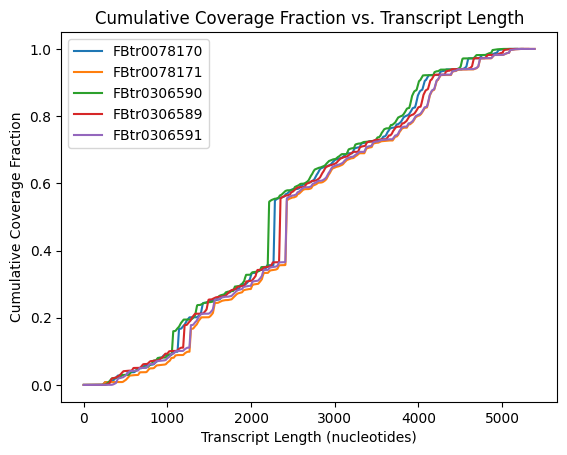

In [14]:
# # Plot cumulative coverage fraction for the first 5 transcripts,
# # using the actual transcript length (in nucleotides) as the x-axis.
# for i, transcript in enumerate(fly_transcripts[:5]):  # e.g., first 5 transcripts
#     my_vector = FMR1_count_vectors[i]
#     # Compute cumulative sum of read counts
#     csum = np.cumsum(my_vector)
#     # Compute the cumulative coverage fraction 
#     frac = csum / csum[-1] if csum[-1] > 0 else np.zeros_like(csum)
#     # Use the nucleotide positions as the x-axis
#     x_positions = np.arange(len(my_vector))
    
#     plt.plot(x_positions, frac, label=transcript.get_name())

# plt.xlabel("Transcript Length (nucleotides)")
# plt.ylabel("Cumulative Coverage Fraction")
# plt.title("Cumulative Coverage Fraction vs. Transcript Length")
# plt.legend()
# plt.show()


Define a function called "find_transcript" to search for the index assoicated with the gene name of interest (needs to be exact match)

In [8]:
def find_transcript(gene, transcripts, count_vectors):
    '''
    A function that takes the name of a gene as input and finds 
    the corresponding transcript from a transcript list. 
    
    returns both the transcript in question and the vector of counts for that transcript.
    '''
    
    for i in transcripts:
        if i.attr['gene_name'] == gene:
            my_transcript = i
            my_vector = count_vectors[transcripts.index(i)]
            index = transcripts.index(i)
            print(f"Index of the transcript: {index}")  # Print the index
            return my_transcript, my_vector  # Return the transcript and the count vector

    return None, None  # Return None if no transcript is found



## In this section, we will look at the CLIP counts for FMR1

Define a gene name and look for the transcript index

In [16]:
my_gene = "poe"
find_transcript(my_gene, fly_transcripts, FMR1_count_vectors)

Index of the transcript: 1601


(<Transcript segments=13 bounds=2L:8054321-8071624(-) name=FBtr0079545>,
 array([0., 0., 0., ..., 0., 0., 0.]))

This is a test to plot counts along the poe transcript

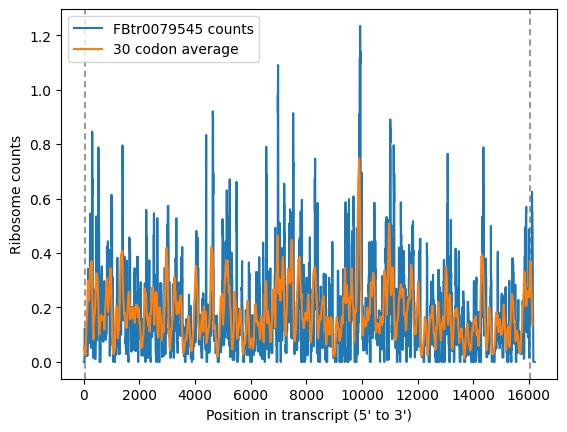

In [17]:
my_transcript = fly_transcripts[1601]
my_vector = FMR1_count_vectors[1601]


plt.plot(my_vector,label="%s counts" % my_transcript.get_name())
window = numpy.ones(90).astype(float)/90.0
sliding_window_avg = numpy.convolve(my_vector,window,mode="valid")
plt.plot(sliding_window_avg,label="30 codon average")
plt.xlabel("Position in transcript (5' to 3')")
plt.ylabel("Ribosome counts")

# add outlines at start & stop codons
plt.axvline(my_transcript.cds_start,color="#999999",dashes=[3,2],zorder=-1)
plt.axvline(my_transcript.cds_end,color="#999999",dashes=[3,2],zorder=-1)

plt.legend()
plt.savefig(os.path.join(FMR1_plot_path, "Poe read counts bar plot"), dpi=1200)
plt.show()

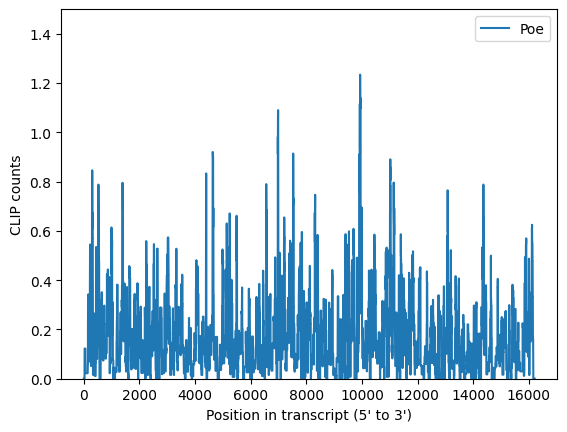

In [16]:
# ----- FMR1 CLIP Plot -----
# FMR1 CLIP count max is 1.5 (DDX3X y axis is 0.5)
my_transcript = fly_transcripts[1601]
my_vector = FMR1_count_vectors[1601]

plt.figure()
plt.plot(my_vector, label="Poe")
plt.xlabel("Position in transcript (5' to 3')")
plt.ylabel("CLIP counts")
plt.ylim(0, 1.5)

plt.legend()
plt.savefig(os.path.join(FMR1_plot_path, "Poe read counts bar plot v2.png"), dpi=1200)
plt.show()

Creat even transcripts (1 count at each nucleotide poisition)

In [8]:
# create stimulated even transcripts for each transcript
FMR1_stimulated_count_vectors = []

for tran in fly_transcripts:
    FMR1_stimulated_count_vectors.append([1] * tran.length)
    
# # sanity check to confirm stimulated count vectors match the length of actual transcripts
# test_vector = stimulated_count_vectors[1]
# test_transcript = transcripts[1]
# test_transcript.length, len(test_vector)
# test_vector[1:10]

In [ ]:
# DDX3X_stimulated_count_vectors = []
# for tran in human_transcripts:
#     DDX3X_stimulated_count_vectors.append([1] * tran.length)


Plot read density for both stiumated even transcript for gene of interest and the actual CLIP read density

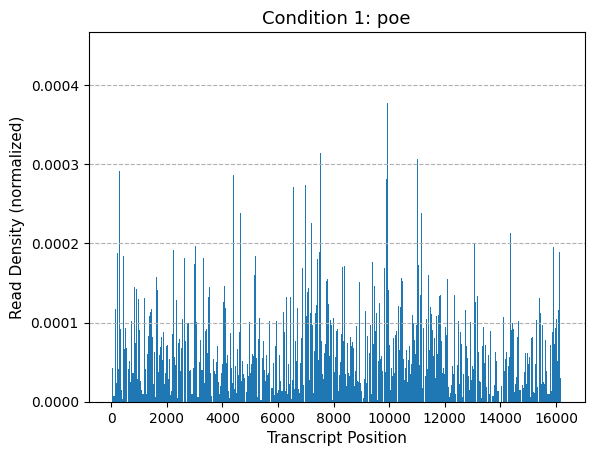

In [58]:
# # choose a gene of interest by index 
# goi_index = 2258
# goi = "poe"  

# # Extract the count arrays for the gene of interest from both conditions
# goi_array_cond1 = np.array(FMR1_count_vectos[goi_index])              # Actual counts
# goi_array_cond2 = np.array(stimulated_count_vectors[goi_index])   # Simulated counts 
# # Normalize the counts by dividing by their total sum to get read density
# norm_cond1 = goi_array_cond1 / goi_array_cond1.sum()
# norm_cond2 = goi_array_cond2 / goi_array_cond2.sum()

# # Find the maximum read density between both conditions to define the y-axis range
# maxi = max(norm_cond1.max(), norm_cond2.max())

# # Create the bar plot for the actual counts (Condition 1)
# plt.bar(range(len(norm_cond1)), norm_cond1, width=4)
# plt.ylim(0, maxi * 1.1)
# plt.ylabel("Read Density (normalized)", fontsize=11)
# plt.xlabel("Transcript Position", fontsize=11)
# plt.title("Condition 1: " + goi, fontsize=13)
# plt.gca().yaxis.grid(linestyle="--")
# plt.savefig(os.path.join(plot_path, "bar plot of poe counts"), dpi=600) 
# plt.show()

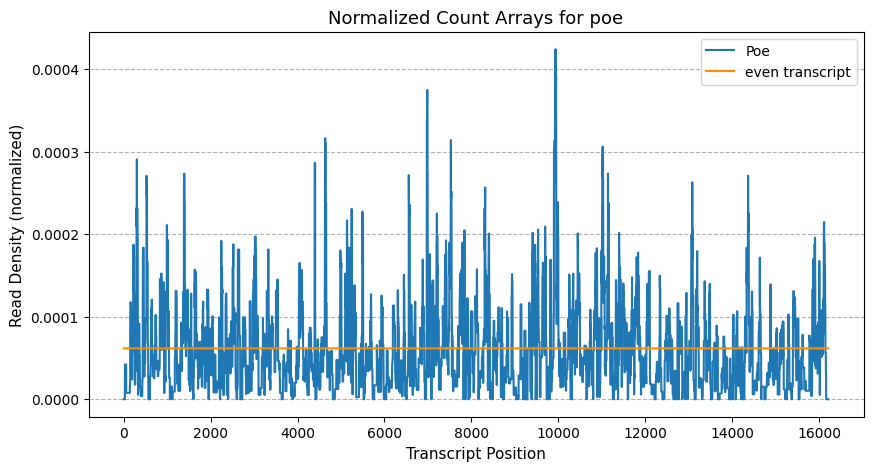

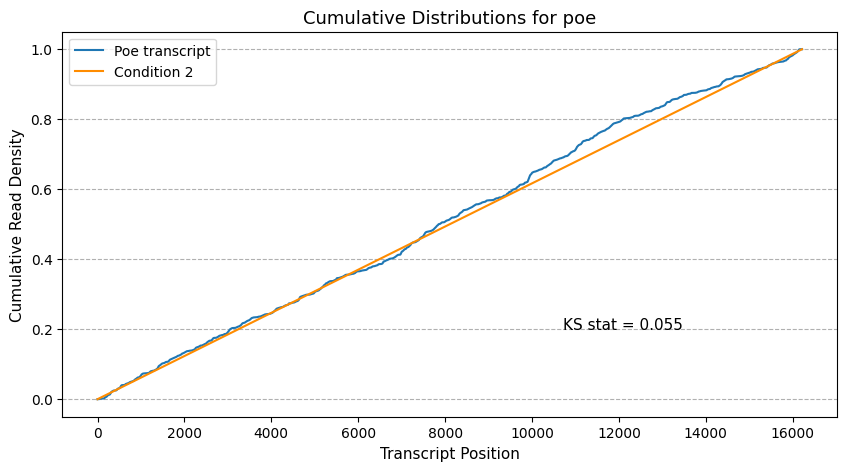

In [20]:
# Choose a gene of interest 
goi_index = 1601
gene_name = "poe"  

# Extract the count arrays for the gene of interest from both conditions
# Condition 1: Actual counts from the BAM file
cond1 = np.array(FMR1_count_vectors[goi_index])
# Condition 2: Simulated counts (even transcript)
cond2 = np.array(FMR1_stimulated_count_vectors[goi_index])

# Normalize the counts to obtain read density profiles
norm_cond1 = cond1 / cond1.sum()
norm_cond2 = cond2 / cond2.sum()

# Compute the cumulative distributions of the normalized arrays
cumul_1 = np.cumsum(norm_cond1)
cumul_2 = np.cumsum(norm_cond2)

# -------------------------------------------
# Plot 1: Normalized Count Arrays (Line Graphs)
# -------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(norm_cond1, label="Poe") # change label to gene name
plt.plot(norm_cond2, label="even transcript", color="darkorange")
plt.ylabel("Read Density (normalized)", fontsize=11)
plt.xlabel("Transcript Position", fontsize=11)
plt.title("Normalized Count Arrays for " + gene_name, fontsize=13)
plt.legend()
plt.gca().yaxis.grid(linestyle="--")
plt.savefig(os.path.join(FMR1_plot_path, "count array for poe"), dpi=1200)
plt.show()

# ---------------------------------------------------
# Plot 2: Cumulative Distributions and K-S Statistic
# ---------------------------------------------------
# Calculate the K-S statistic (maximum difference between cumulative distributions)
ks = max(abs(cumul_1 - cumul_2))

plt.figure(figsize=(10, 5))
plt.plot(cumul_1, label="Poe transcript")
plt.plot(cumul_2, label="Condition 2", color="darkorange")
# Annotate the K-S statistic on the plot; adjust the coordinates as needed.
plt.text(len(cumul_2) * 0.66, 0.2, "KS stat = " + str(round(ks, 3)), fontsize=11)
plt.ylabel("Cumulative Read Density", fontsize=11)
plt.xlabel("Transcript Position", fontsize=11)
plt.title("Cumulative Distributions for " + gene_name, fontsize=13)
plt.legend()
plt.gca().yaxis.grid(linestyle="--")
plt.savefig(os.path.join(FMR1_plot_path, "KS score on poe"), dpi=1200)
plt.show()




Compute KS test on CDF to compare the read coverage along transcript length. If the transcript is coated by the RBP, the KS value will be small and the line for the CDF of gene of interest will be close to a straight line

First, we want to calculate the KS scores for the entire transcript (CDS + 3'UTR + 5'UTR)

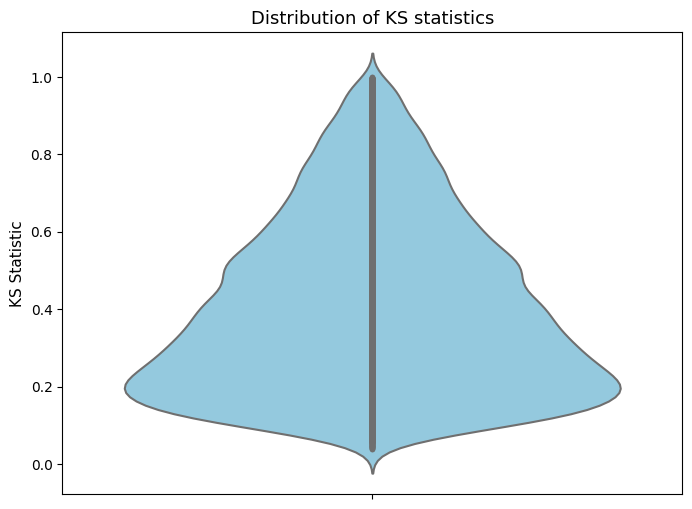

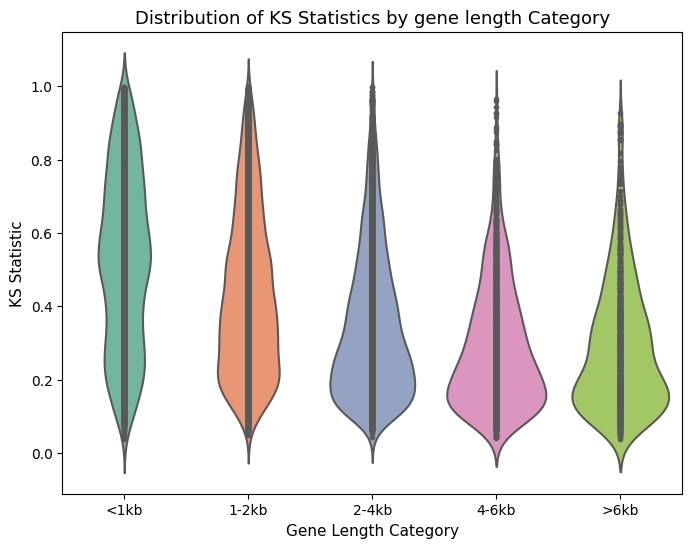

In [12]:
# Initialize lists to store gene lengths, KS values, and transcript attributes
gene_lengths = []
ks_values = []
gene_names = []
transcript_ids = []
gene_ids = []

# Loop over each transcript index
for i in range(len(FMR1_count_vectors)):
    transcript = fly_transcripts[i]
    
    # Extract gene name, transcript ID, and gene ID from the transcript attributes
    gene_name_value = transcript.attr["gene_name"]
    transcript_id_value = transcript.attr["transcript_id"]
    gene_id_value = transcript.attr["gene_id"]
    
    vec_actual = np.array(FMR1_count_vectors[i])
    vec_stim = np.array(FMR1_stimulated_count_vectors[i])
    length = len(vec_actual)
    
    # Skip transcripts with no reads in either condition
    if vec_actual.sum() == 0 or vec_stim.sum() == 0:
        continue
    
    # Normalize counts to get read density profiles
    norm_actual = vec_actual / vec_actual.sum()
    norm_stim = vec_stim / vec_stim.sum()
    
    # Compute cumulative distributions (CDFs)
    cdf_actual = np.cumsum(norm_actual)
    cdf_stim = np.cumsum(norm_stim)
    
    # Calculate KS statistic as the maximum absolute difference between the CDFs
    ks = np.max(np.abs(cdf_actual - cdf_stim))
    
    # Append computed values and attributes to their lists
    gene_lengths.append(length)
    ks_values.append(ks)
    gene_names.append(gene_name_value)
    transcript_ids.append(transcript_id_value)
    gene_ids.append(gene_id_value)

# Create a DataFrame with the results
df = pd.DataFrame({
    "GeneName": gene_names,
    "TranscriptID": transcript_ids,
    "GeneID": gene_ids,
    "GeneLength": gene_lengths,
    "KS": ks_values
})

# Filter out duplicate GeneName rows, keeping the one with the longest GeneLength.
# First, sort by GeneLength in descending order, then drop duplicates on GeneName.
df_unique = df.sort_values("GeneLength", ascending=False).drop_duplicates(subset="GeneName")

# Define the output file name using os.path.join
output_file = os.path.join(FMR1_output_path, "KS score FMR1 CLIP all transcripts.csv")

# Save the filtered DataFrame to a CSV file without the index
df_unique.to_csv(output_file, index=False)
# ---------------------------------------------------------------------
# violin plot of KS distribution for all transcripts
# ---------------------------------------------------------------------
plt.figure(figsize=(8, 6))
sns.violinplot(y=df["KS"], inner="point", color="skyblue")
plt.ylabel("KS Statistic", fontsize=11)
plt.title("Distribution of KS statistics", fontsize=13)
plt.savefig(os.path.join(FMR1_plot_path, "Distribution of KS statistics for all FMR1 CLIP targets"), dpi=600)  
plt.show()


bins = [0, 1000, 2000, 4000, 6000, np.inf]
labels = ["<1kb", "1-2kb", "2-4kb", "4-6kb", ">6kb"]
df["LengthCategory"] = pd.cut(df["GeneLength"], bins=bins, labels=labels)

# 2. Plot a violin plot with separate violins for each category
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, x="LengthCategory", y="KS", inner="point", palette="Set2")
plt.xlabel("Gene Length Category", fontsize=11)
plt.ylabel("KS Statistic", fontsize=11)
plt.title("Distribution of KS Statistics by gene length Category", fontsize=13)
plt.savefig(os.path.join(FMR1_plot_path, "Distribution of KS score acorss entire gene length for FMR1 CLIP targets"), dpi=600)  
plt.show()


For FMR1 CLIP, since it binds mostly to the CDS, we want to calculate the KS scores for CDS only

Heatmap and scatter plot of KS score vs gene length

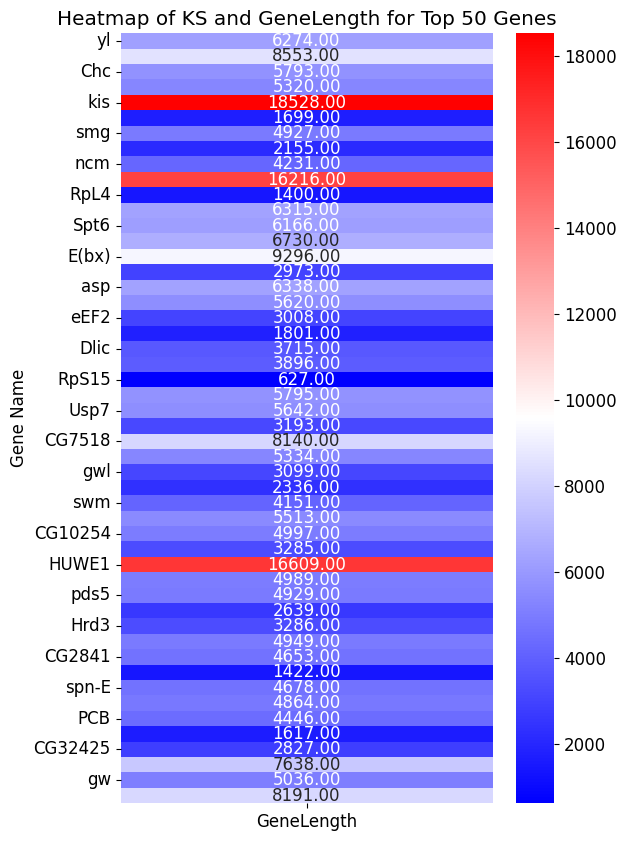

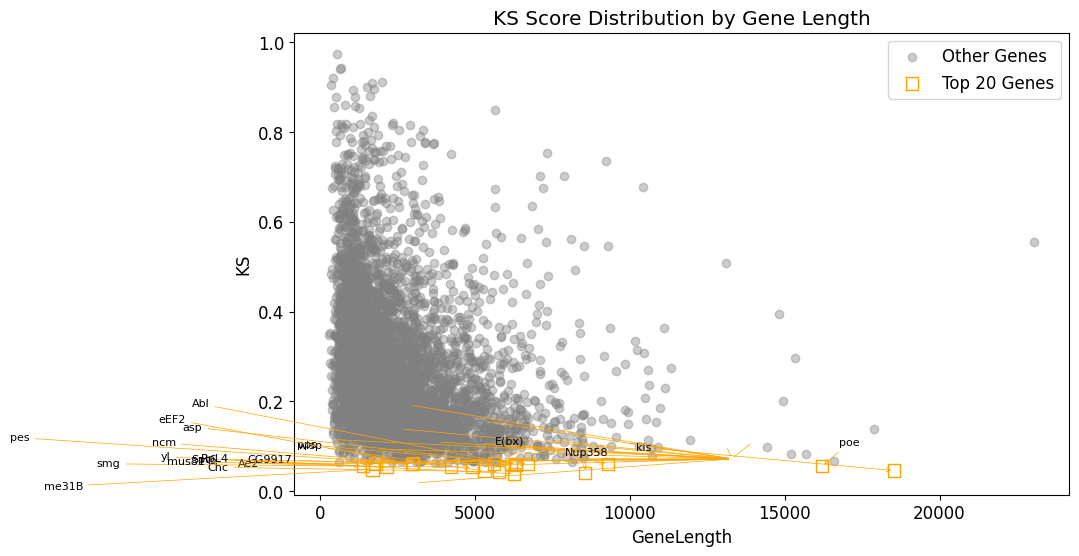

In [29]:
file_path = os.path.join(FMR1_output_path, "KS score FMR1 CLIP all transcripts.csv")
df = pd.read_csv(file_path)

# Select top 50 genes by KS score (lowest KS first; adjust as needed)
df_top50 = df.sort_values("KS", ascending=True).head(50)

# Create a DataFrame for the heatmap and set GeneName as the index
df_heatmap = df_top50[["GeneName","GeneLength"]].set_index("GeneName")

# Create a custom diverging colormap: blue for low, white for middle, red for high
custom_cmap = LinearSegmentedColormap.from_list("custom_bwr", ["blue", "white", "red"])

# Generate the heatmap
plt.figure(figsize=(6, 10))  # Adjust the figure size as needed
sns.heatmap(
    df_heatmap, 
    cmap=custom_cmap,   # Use the custom colormap
    annot=True,         # Annotate cells with their values
    fmt=".2f"           # Format numbers to 2 decimal places
)

plt.title("Heatmap of KS and GeneLength for Top 50 Genes")
plt.ylabel("Gene Name")
plt.show()

#######################################
############ Scatter plot #############
#######################################

df_sorted = df.sort_values("KS", ascending=True)
top20_indices = df_sorted.head(20).index
df["Top20"] = df.index.isin(top20_indices)

plt.figure(figsize=(10, 6))

# Plot non–top50 genes as transparent grey dots
plt.scatter(
    df.loc[~df["Top20"], "GeneLength"], 
    df.loc[~df["Top20"], "KS"],
    color="grey", 
    label="Other Genes",
    alpha=0.4  
)

# Plot top 50 genes as empty orange squares
plt.scatter(
    df.loc[df["Top20"], "GeneLength"], 
    df.loc[df["Top20"], "KS"],
    facecolors='none',   # empty marker
    edgecolors="orange", 
    marker="s",          # square marker
    s=80,               # marker size
    label="Top 20 Genes"
)

# Annotate each top 50 gene with  GeneName 
texts = []
for idx, row in df[df["Top20"]].iterrows():
    texts.append(plt.annotate(
        row["GeneName"],
        (row["GeneLength"], row["KS"]),
        textcoords="offset points",
        xytext=(5, 5),
        fontsize=8,
        arrowprops=dict(arrowstyle="->", color='orange', lw=0.5)
    ))

adjust_text(texts, arrowprops=dict(arrowstyle="->", color='orange', lw=0.5))

plt.xlabel("GeneLength")
plt.ylabel("KS")
plt.title("KS Score Distribution by Gene Length")
plt.legend()
plt.show()


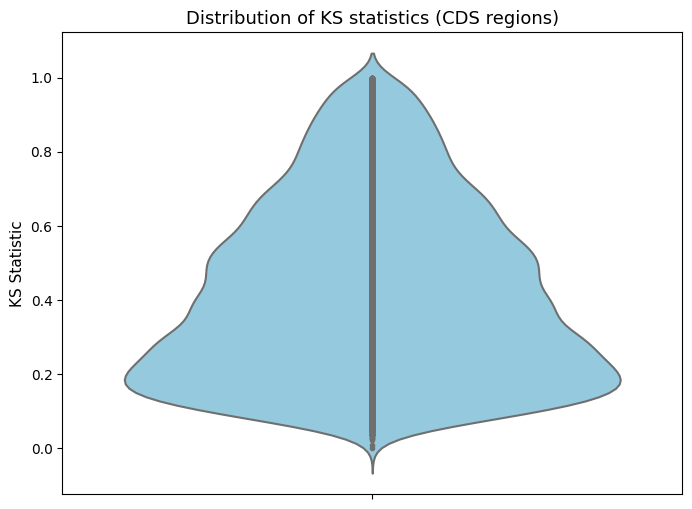

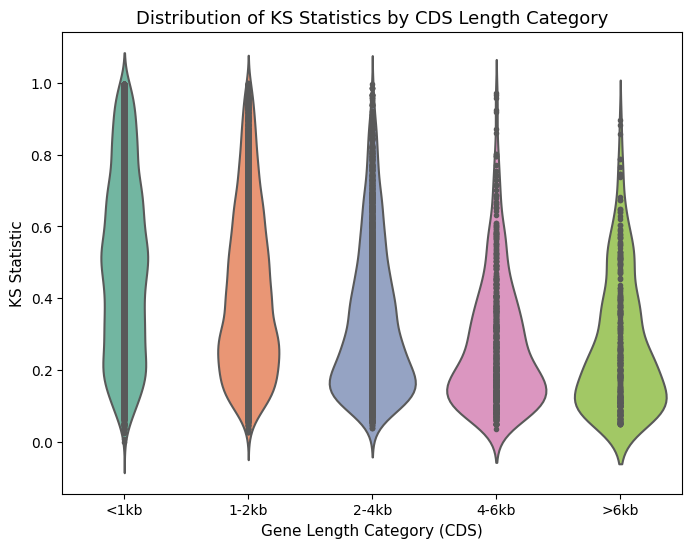

In [22]:
# Initialize lists to store gene lengths and KS values
gene_lengths = []
ks_values = []

# Initialize lists to store CDS-filtered count vectors
cds_count_vectors = []
cds_stim_vectors = []

# Subset each count array to only the CDS region and create a stimulated vector of ones
for i in range(len(FMR1_count_vectors)):
    # Get the CDS start and end positions for the transcript
    cds_start = fly_transcripts[i].cds_start
    cds_end = fly_transcripts[i].cds_end

    # Subset the count vectors to the CDS region
    cds_actual = FMR1_count_vectors[i][cds_start:cds_end]
    # Create a stimulated vector of the same length with count 1 at each nucleotide
    cds_stim = [1] * (cds_end - cds_start)
    
    cds_count_vectors.append(cds_actual)
    cds_stim_vectors.append(cds_stim)

# Loop over each transcript using the CDS-filtered vectors
for i in range(len(cds_count_vectors)):
    vec_actual = np.array(cds_count_vectors[i])
    vec_stim = np.array(cds_stim_vectors[i])
    length = len(vec_actual)
    
    # Skip transcripts with no reads in either condition
    if vec_actual.sum() == 0 or vec_stim.sum() == 0:
        continue
    
    # Normalize counts to get read density profiles
    norm_actual = vec_actual / vec_actual.sum()
    norm_stim = vec_stim / vec_stim.sum()
    
    # Compute cumulative distributions (CDFs)
    cdf_actual = np.cumsum(norm_actual)
    cdf_stim = np.cumsum(norm_stim)
    
    # Calculate KS statistic as the maximum absolute difference between the CDFs
    ks = np.max(np.abs(cdf_actual - cdf_stim))
    
    gene_lengths.append(length)
    ks_values.append(ks)

# Create a DataFrame with the results
df = pd.DataFrame({
    "GeneLength": gene_lengths,
    "KS": ks_values
})

# ---------------------------------------------------------------------
# Violin plot of KS distribution for all transcripts
# ---------------------------------------------------------------------
plt.figure(figsize=(8, 6))
sns.violinplot(y=df["KS"], inner="point", color="skyblue")
plt.ylabel("KS Statistic", fontsize=11)
plt.title("Distribution of KS statistics (CDS regions)", fontsize=13)
plt.savefig(os.path.join(FMR1_plot_path, "Distribution of KS statistics_CDS"), dpi=600)
plt.show()

# Create gene length categories based on CDS lengths
bins = [0, 1000, 2000, 4000, 6000, np.inf]
labels = ["<1kb", "1-2kb", "2-4kb", "4-6kb", ">6kb"]
df["LengthCategory"] = pd.cut(df["GeneLength"], bins=bins, labels=labels)

# 2. Plot a violin plot with separate violins for each category
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, x="LengthCategory", y="KS", inner="point", palette="Set2")
plt.xlabel("Gene Length Category (CDS)", fontsize=11)
plt.ylabel("KS Statistic", fontsize=11)
plt.title("Distribution of KS Statistics by CDS Length Category", fontsize=13)
plt.savefig(os.path.join(FMR1_plot_path, "Distribution of KS Statistics by CDS Length Category"), dpi=600)
plt.show()


To only calculate the counts for 1kb of CDS region (from the start to the first 1000 nts of CDS region)

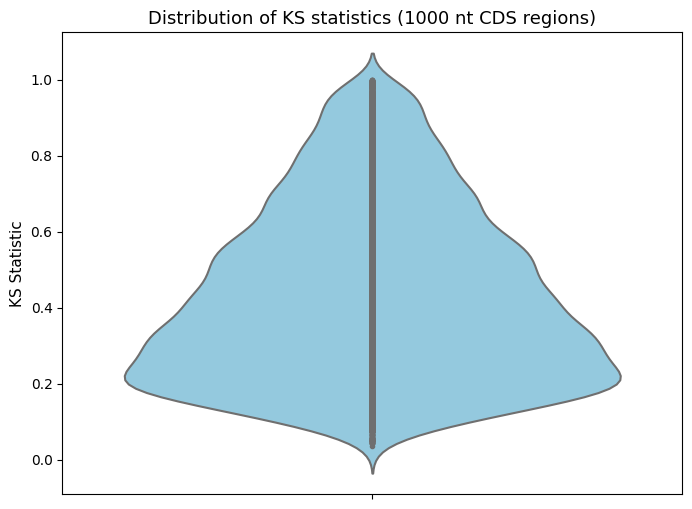

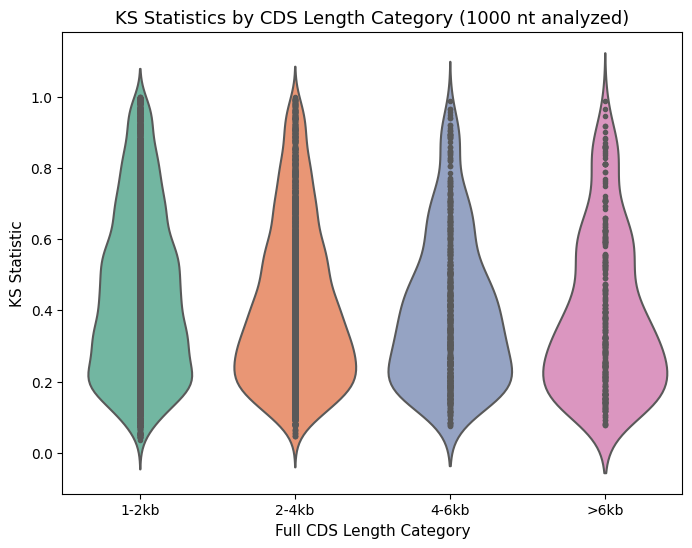

In [23]:
# Initialize lists to store full CDS lengths and KS values
full_cds_lengths = []
ks_values = []

# Loop over each transcript index
for i in range(len(FMR1_count_vectors)):
    # Get the CDS start and end positions for the transcript
    cds_start = fly_transcripts[i].cds_start
    cds_end = fly_transcripts[i].cds_end
    cds_length = cds_end - cds_start

    # Exclude transcripts with a CDS shorter than 1000 nucleotides
    if cds_length < 1000:
        continue

    # Subset the count vector to the first 1000 nucleotides of the CDS region
    cds_actual = FMR1_count_vectors[i][cds_start:cds_start+1000]
    # Create a stimulated vector of ones (length = 1000)
    cds_stim = [1] * 1000

    # Convert lists to numpy arrays for computation
    vec_actual = np.array(cds_actual)
    vec_stim = np.array(cds_stim)
    
    # Skip transcripts with no reads in either condition
    if vec_actual.sum() == 0 or vec_stim.sum() == 0:
        continue

    # Normalize counts to get read density profiles
    norm_actual = vec_actual / vec_actual.sum()
    norm_stim = vec_stim / vec_stim.sum()

    # Compute cumulative distributions (CDFs)
    cdf_actual = np.cumsum(norm_actual)
    cdf_stim = np.cumsum(norm_stim)

    # Calculate the KS statistic as the maximum absolute difference between the CDFs
    ks = np.max(np.abs(cdf_actual - cdf_stim))

    # Record the full CDS length and the computed KS statistic
    full_cds_lengths.append(cds_length)
    ks_values.append(ks)

# Create a DataFrame with the results
df = pd.DataFrame({
    "FullCDSLength": full_cds_lengths,
    "KS": ks_values
})

# ---------------------------------------------------------------------
# Violin plot of KS distribution for all transcripts (1000 nt analyzed)
# ---------------------------------------------------------------------
plt.figure(figsize=(8, 6))
sns.violinplot(y=df["KS"], inner="point", color="skyblue")
plt.ylabel("KS Statistic", fontsize=11)
plt.title("Distribution of KS statistics (1000 nt CDS regions)", fontsize=13)
plt.savefig(os.path.join(FMR1_plot_path, "Distribution of KS scores for 1 kb region of CDS for all transcripts"), dpi=600)
plt.show()

# Create gene length categories based on the full CDS lengths (only transcripts with CDS >= 1000 nt)
bins = [1000, 2000, 4000, 6000, np.inf]
labels = ["1-2kb", "2-4kb", "4-6kb", ">6kb"]
df["LengthCategory"] = pd.cut(df["FullCDSLength"], bins=bins, labels=labels, right=False)

# 2. Violin plot: KS distribution by full CDS length category
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, x="LengthCategory", y="KS", inner="point", palette="Set2")
plt.xlabel("Full CDS Length Category", fontsize=11)
plt.ylabel("KS Statistic", fontsize=11)
plt.title("KS Statistics by CDS Length Category (1000 nt analyzed)", fontsize=13)
plt.savefig(os.path.join(FMR1_plot_path, "Distribution of KS scores for 1 kb region of CDS by CDS length"), dpi=600)
plt.show()



To only calculate the counts for 1kb of CDS region (random 1kb region across the entire CDS length)

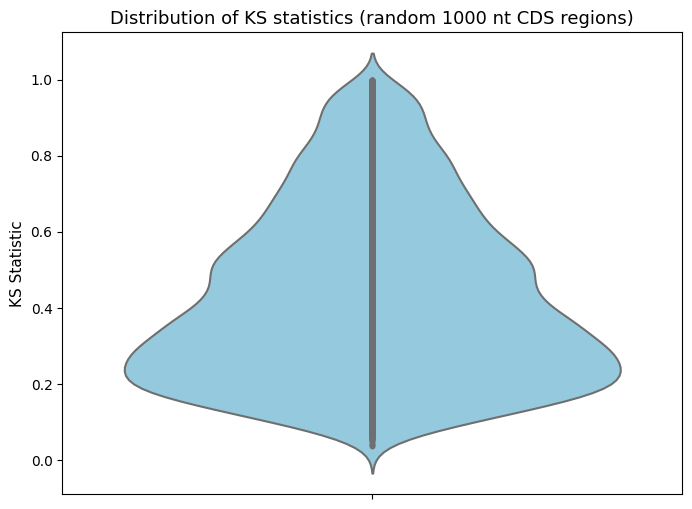

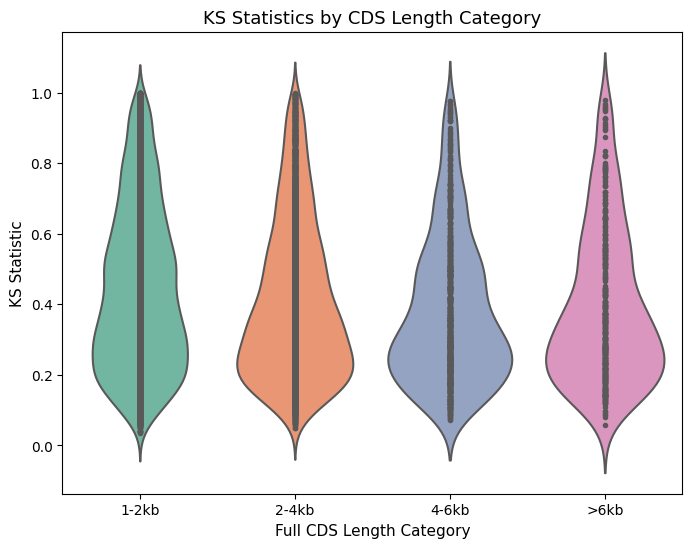

In [24]:
# Initialize lists to store full CDS lengths and KS values for qualifying transcripts
full_cds_lengths = []
ks_values = []

# Loop over each transcript index
for i in range(len(FMR1_count_vectors)):
    # Get CDS coordinates
    cds_start = fly_transcripts[i].cds_start
    cds_end = fly_transcripts[i].cds_end
    cds_length = cds_end - cds_start

    # Exclude transcripts with a CDS shorter than 1000 nucleotides
    if cds_length < 1000:
        continue

    # Randomly select a starting position for a 1000 nt region within the CDS
    rand_offset = random.randint(0, cds_length - 1000)
    rand_start = cds_start + rand_offset

    # Subset the count vector to the 1000 nt region starting at rand_start
    cds_actual = FMR1_count_vectors[i][rand_start:rand_start+1000]
    # Create a stimulated vector of ones (length = 1000)
    cds_stim = [1] * 1000

    # Convert lists to numpy arrays for computation
    vec_actual = np.array(cds_actual)
    vec_stim = np.array(cds_stim)

    # Skip transcripts with no reads in either condition
    if vec_actual.sum() == 0 or vec_stim.sum() == 0:
        continue

    # Normalize counts to get read density profiles
    norm_actual = vec_actual / vec_actual.sum()
    norm_stim = vec_stim / vec_stim.sum()

    # Compute cumulative distributions (CDFs)
    cdf_actual = np.cumsum(norm_actual)
    cdf_stim = np.cumsum(norm_stim)

    # Calculate KS statistic as the maximum absolute difference between the CDFs
    ks = np.max(np.abs(cdf_actual - cdf_stim))

    # Only now append to both lists, ensuring they are of the same length
    full_cds_lengths.append(cds_length)
    ks_values.append(ks)

# Create a DataFrame with the results
df = pd.DataFrame({
    "FullCDSLength": full_cds_lengths,
    "KS": ks_values
})

# ---------------------------------------------------------------------
# Violin plot of KS distribution for all transcripts (random 1000 nt analyzed)
# ---------------------------------------------------------------------
plt.figure(figsize=(8, 6))
sns.violinplot(y=df["KS"], inner="point", color="skyblue")
plt.ylabel("KS Statistic", fontsize=11)
plt.title("Distribution of KS statistics (random 1000 nt CDS regions)", fontsize=13)
plt.savefig(os.path.join(FMR1_plot_path, "Distribution of KS scores for random 1 kb region of CDS for all transcripts"), dpi=600)
plt.show()

# Create gene length categories based on the full CDS lengths (only transcripts with CDS >= 1000 nt)
bins = [1000, 2000, 4000, 6000, np.inf]
labels = ["1-2kb", "2-4kb", "4-6kb", ">6kb"]
df["LengthCategory"] = pd.cut(df["FullCDSLength"], bins=bins, labels=labels, right=False)

# Violin plot: KS distribution by full CDS length category
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, x="LengthCategory", y="KS", inner="point", palette="Set2")
plt.xlabel("Full CDS Length Category", fontsize=11)
plt.ylabel("KS Statistic", fontsize=11)
plt.title("KS Statistics by CDS Length Category", fontsize=13)
plt.savefig(os.path.join(FMR1_plot_path, "Distribution of KS by random 1kb CDS Length Category random"), dpi=600)
plt.show()

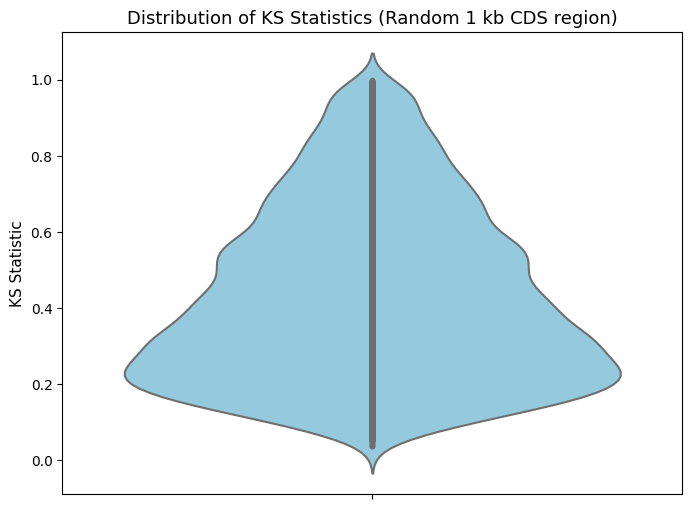

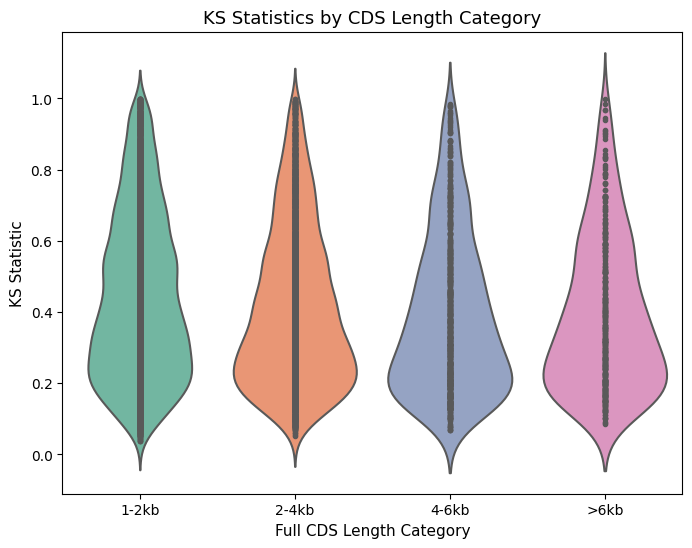

DataFrame saved to /Volumes/T1_Crystal/Greenblatt_lab/Me31B_Fmr1_KD_library1/FMR1_KS_results.csv


In [6]:
def compute_ks(count_vector, transcript, window=1000):
    """
    Compute the KS statistic for a random window (default 1 kb) within the CDS region.
    Returns a tuple (full_CDS_length, ks) or None if the CDS is too short or has zero reads.
    """
    cds_start = transcript.cds_start
    cds_end = transcript.cds_end
    cds_length = cds_end - cds_start
    if cds_length < window:
        return None
    rand_offset = random.randint(0, cds_length - window)
    start = cds_start + rand_offset
    vec = np.array(count_vector[start:start+window])
    stim = np.ones(window, dtype=int)
    if vec.sum() == 0 or stim.sum() == 0:
        return None
    norm_actual = vec / vec.sum()
    norm_stim = stim / stim.sum()
    ks = np.max(np.abs(np.cumsum(norm_actual) - np.cumsum(norm_stim)))
    return cds_length, ks

# Process FMR1 transcripts and collect results
results = []
for count_vector, transcript in zip(FMR1_count_vectors, fly_transcripts):
    res = compute_ks(count_vector, transcript, window=1000)
    if res is None:
        continue
    full_length, ks = res
    results.append({
        "GeneName": transcript.attr["gene_name"],
        "TranscriptID": transcript.attr["transcript_id"],
        "GeneID": transcript.attr["gene_id"],
        "FullCDSLength": full_length,
        "KS": ks
    })

df = pd.DataFrame(results)

# Create CDS length categories
bins = [1000, 2000, 4000, 6000, np.inf]
labels = ["1-2kb", "2-4kb", "4-6kb", ">6kb"]
df["LengthCategory"] = pd.cut(df["FullCDSLength"], bins=bins, labels=labels, right=False)

# -------------------------------
# Plot 1: Overall KS Distribution
# -------------------------------
plt.figure(figsize=(8, 6))
sns.violinplot(y=df["KS"], inner="point", color="skyblue")
plt.ylabel("KS Statistic", fontsize=11)
plt.title("Distribution of KS Statistics (Random 1 kb CDS region)", fontsize=13)
plt.savefig(os.path.join(FMR1_plot_path, "FMR1_KS_distribution_overall.png"), dpi=600)
plt.show()

# --------------------------------------------------
# Plot 2: KS Distribution by CDS Length Category
# --------------------------------------------------
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, x="LengthCategory", y="KS", inner="point", palette="Set2")
plt.xlabel("Full CDS Length Category", fontsize=11)
plt.ylabel("KS Statistic", fontsize=11)
plt.title("KS Statistics by CDS Length Category", fontsize=13)
plt.savefig(os.path.join(FMR1_plot_path, "FMR1_KS_distribution_by_length.png"), dpi=600)
plt.show()

# Save the DataFrame to CSV
output_csv = os.path.join(FMR1_output_path, "FMR1_KS_results.csv")
df.to_csv(output_csv, index=False)
print("DataFrame saved to", output_csv)


## In this section, we will look at the CLIP counts for DDX3X

In [30]:
# find transcript index 

my_gene = "UBR4"
find_transcript(my_gene, human_transcripts, DDX3X_count_vectors)
# sum(DDX3X_count_vectors[407])

Index of the transcript: 407


371.99999999998903

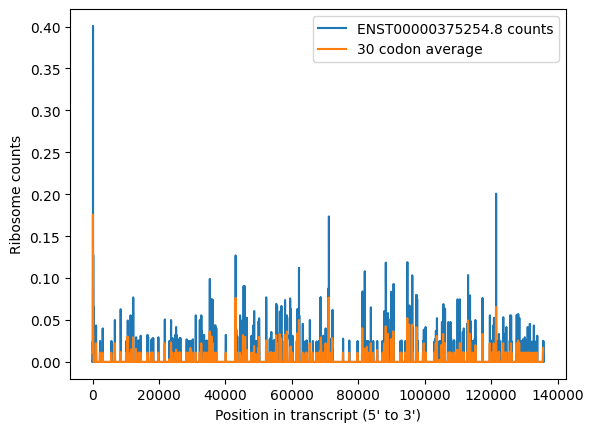

In [15]:
# Find the transcript index for gene "UBR4"
my_transcript = human_transcripts[407]
my_vector = DDX3X_count_vectors[407]


plt.plot(my_vector,label="%s counts" % my_transcript.get_name())
window = numpy.ones(90).astype(float)/90.0
sliding_window_avg = numpy.convolve(my_vector,window,mode="valid")
plt.plot(sliding_window_avg,label="30 codon average")
plt.xlabel("Position in transcript (5' to 3')")
plt.ylabel("Ribosome counts")

# # add outlines at start & stop codons
# plt.axvline(my_transcript.cds_start,color="#999999",dashes=[3,2],zorder=-1)
# plt.axvline(my_transcript.cds_end,color="#999999",dashes=[3,2],zorder=-1)

plt.legend()
plt.savefig(os.path.join(DDX3X_plot_path, "UBR4 read counts bar plot"), dpi=1200)
plt.show()




In [13]:
# Set gene of interest by name
my_gene = "UBR4"  
goi_index = 407

# Find the gene's index directly
for i, transcript in enumerate(human_transcripts):
    if transcript.attr['gene_name'] == my_gene:
        goi_index = i
        print(f"Found '{my_gene}' at index {goi_index}")
        break
else:
    print(f"Gene '{my_gene}' not found.")
    goi_index = None

# Proceed only if gene was found
if goi_index is not None:
    # Extract count arrays for both conditions
    goi_array_cond1 = np.array(DDX3X_count_vectors[goi_index])            # Actual counts
    goi_array_cond2 = np.array(DDX3X_stimulated_count_vectors[goi_index]) # Stimulated counts

    # Normalize counts to get read density
    norm_cond1 = goi_array_cond1 / goi_array_cond1.sum()
    norm_cond2 = goi_array_cond2 / goi_array_cond2.sum()

    # Determine maximum for y-axis scaling
    maxi = max(norm_cond1.max(), norm_cond2.max())

    # Plot Condition 1
    plt.bar(range(len(norm_cond1)), norm_cond1, width=4)
    plt.ylim(0, maxi * 1.1)
    plt.ylabel("Read Density (normalized)", fontsize=11)
    plt.xlabel("Transcript Position", fontsize=11)
    plt.title(f"Condition 1: {my_gene}", fontsize=13)
    plt.gca().yaxis.grid(linestyle="--")
    plt.savefig(os.path.join(DDX3X_plot_path, f"{my_gene}_counts_barplot.png"), dpi=600)
    plt.show()

Found 'UBR4' at index 406


NameError: name 'DDX3X_stimulated_count_vectors' is not defined

Found 'UBR4' at index 407


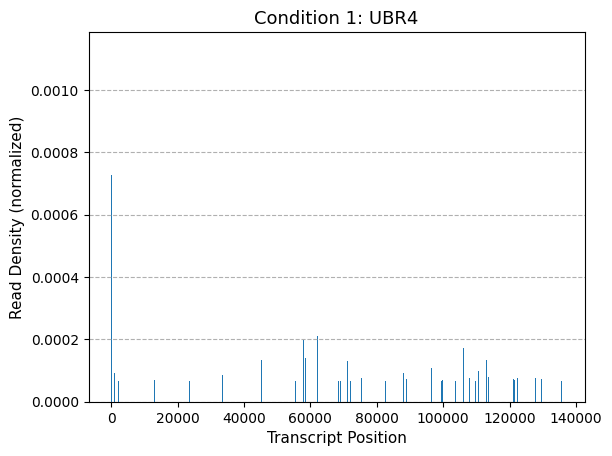

In [18]:
# Example generator for stimulated counts
def stimulated_counts_generator(transcripts):
    """Yield a stimulated counts vector (all ones) for each transcript."""
    for tran in transcripts:
        yield np.ones(tran.length, dtype=int)

# Set gene of interest by name
my_gene = "UBR4"

# Find the gene's index directly in human_transcripts
goi_index = None
for i, transcript in enumerate(human_transcripts):
    if transcript.attr['gene_name'] == my_gene:
        goi_index = i
        print(f"Found '{my_gene}' at index {goi_index}")
        break
else:
    print(f"Gene '{my_gene}' not found.")

# Proceed only if the gene was found
if goi_index is not None:
    # Extract count arrays for condition 1 (actual counts)
    goi_array_cond1 = np.array(DDX3X_count_vectors[goi_index])
    
    # Use the generator to get the stimulated counts for the transcript of interest.
    # Instead of pre-creating a list for all transcripts, we iterate until we reach our index.
    stim_gen = stimulated_counts_generator(human_transcripts)
    for idx, stim_vector in enumerate(stim_gen):
        if idx == goi_index:
            goi_array_cond2 = stim_vector
            break

    # Normalize counts to get read density
    norm_cond1 = goi_array_cond1 / goi_array_cond1.sum()
    norm_cond2 = goi_array_cond2 / goi_array_cond2.sum()

    # Determine maximum value for y-axis scaling
    maxi = max(norm_cond1.max(), norm_cond2.max())

    # Plot Condition 1 read density
    plt.bar(range(len(norm_cond1)), norm_cond1, width=4)
    plt.ylim(0, maxi * 1.1)
    plt.ylabel("Read Density (normalized)", fontsize=11)
    plt.xlabel("Transcript Position", fontsize=11)
    plt.title(f"Condition 1: {my_gene}", fontsize=13)
    plt.gca().yaxis.grid(linestyle="--")
    
    # Save the figure
    output_path = os.path.join(DDX3X_plot_path, f"{my_gene}_counts_barplot.png")
    plt.savefig(output_path, dpi=600)
    plt.show()


In [ ]:
# Choose a gene of interest by gene name
goi = "UBR4"

# Automatically find the gene index
for i, transcript in enumerate(human_transcripts):
    if transcript.attr['gene_name'] == goi:
        goi_index = i
        print(f"Found '{goi}' at index {goi_index}")
        break
else:
    print(f"Gene '{goi}' not found.")
    goi_index = None

# Proceed only if the gene was found
if goi_index is not None:
    # Extract count arrays for both conditions
    cond1 = np.array(DDX3X_count_vectors[goi_index])  # Actual counts
    cond2 = np.array(DDX3X_stimulated_count_vectors[goi_index])  # Simulated counts

    # Normalize the counts to obtain read density profiles
    norm_cond1 = cond1 / cond1.sum()
    norm_cond2 = cond2 / cond2.sum()

    # Compute cumulative distributions
    cumul_1 = np.cumsum(norm_cond1)
    cumul_2 = np.cumsum(norm_cond2)

    # -------------------------------------------
    # Plot 1: Normalized Count Arrays (Line Graphs)
    # -------------------------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(norm_cond1, label=f"{goi}")
    plt.plot(norm_cond2, label="Even transcript", color="darkorange")
    plt.ylabel("Read Density (normalized)", fontsize=11)
    plt.xlabel("Transcript Position", fontsize=11)
    plt.title(f"Normalized Count Arrays for {goi}", fontsize=13)
    plt.legend()
    plt.gca().yaxis.grid(linestyle="--")
    plt.savefig(os.path.join(DDX3X_plot_path, f"normalized_counts_{goi}.png"), dpi=1200)
    plt.show()

    # ---------------------------------------------------
    # Plot 2: Cumulative Distributions and K-S Statistic
    # ---------------------------------------------------
    # Calculate the K-S statistic
    ks = max(abs(cumul_1 - cumul_2))

    plt.figure(figsize=(10, 5))
    plt.plot(cumul_1, label=f"{goi} transcript")
    plt.plot(cumul_2, label="Even transcript", color="darkorange")
    # Annotate the K-S statistic
    plt.text(len(cumul_2) * 0.66, 0.2, f"KS stat = {ks:.3f}", fontsize=11)
    plt.ylabel("Cumulative Read Density", fontsize=11)
    plt.xlabel("Transcript Position", fontsize=11)
    plt.title(f"Cumulative Distributions for {goi}", fontsize=13)
    plt.legend()
    plt.gca().yaxis.grid(linestyle="--")
    plt.savefig(os.path.join(DDX3X_plot_path, f"cumulative_KS_{goi}.png"), dpi=1200)
    plt.show()

KS test on all transcripts and on the entire transcript length

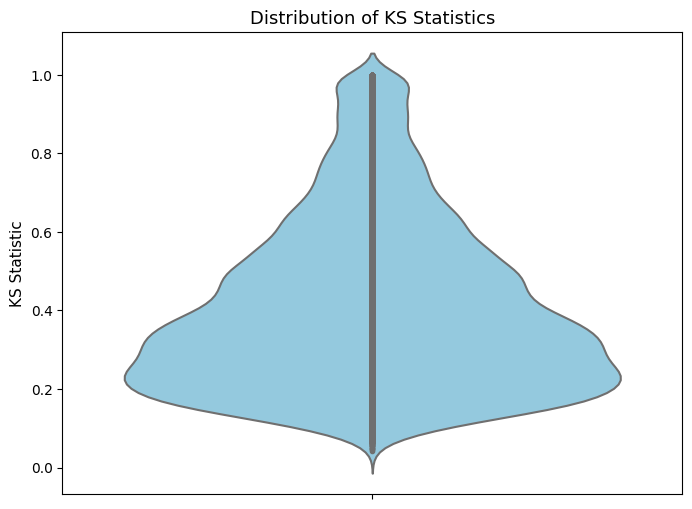

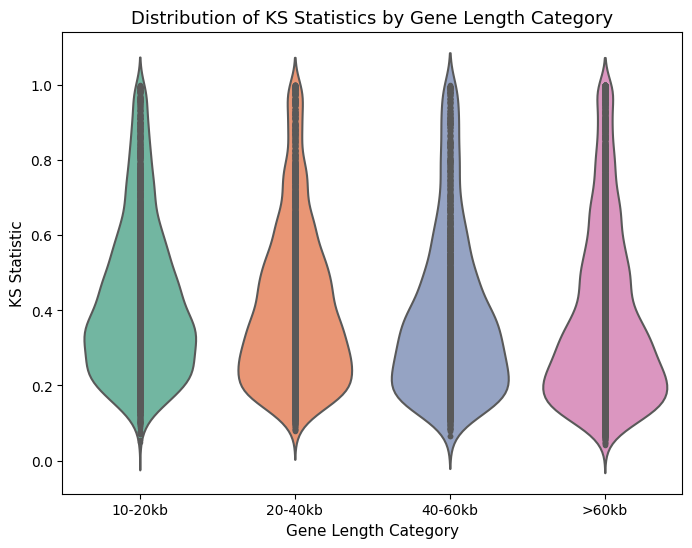

In [15]:
# Generator that yields a stimulated counts vector (all ones) for each transcript.
def stimulated_counts_generator(transcripts):
    """
    For each transcript, yield a NumPy array of ones whose length equals the transcript length.
    """
    for tran in transcripts:
        yield np.ones(tran.length, dtype=int)

# Generator that yields (gene_length, ks_statistic) for each transcript pair.
def ks_generator(count_vectors, transcripts):
    """
    For each pair of actual count vector and stimulated count vector (generated on the fly),
    compute the KS statistic and yield the gene length and KS value.
    """
    # Create stimulated count vectors on demand
    stim_gen = stimulated_counts_generator(transcripts)
    
    for vec_actual, vec_stim in zip(count_vectors, stim_gen):
        # Convert to numpy arrays in case they're not already
        vec_actual = np.array(vec_actual)
        vec_stim = np.array(vec_stim)
        
        # Skip transcripts with zero total reads in either condition
        if vec_actual.sum() == 0 or vec_stim.sum() == 0:
            continue

        # Normalize counts to obtain read density profiles
        norm_actual = vec_actual / vec_actual.sum()
        norm_stim = vec_stim / vec_stim.sum()

        # Compute cumulative distributions (CDFs)
        cdf_actual = np.cumsum(norm_actual)
        cdf_stim = np.cumsum(norm_stim)

        # Calculate KS statistic
        ks = np.max(np.abs(cdf_actual - cdf_stim))

        yield len(vec_actual), ks

# Use the generator to process each transcript on-the-fly.
# Note: DDX3X_count_vectors should be defined, and human_transcripts is assumed to be your transcript list
results = list(ks_generator(DDX3X_count_vectors, human_transcripts))
if results:
    gene_lengths, ks_values = zip(*results)
else:
    gene_lengths, ks_values = [], []

# Create a DataFrame from the generator output.
ks_df = pd.DataFrame({"GeneLength": gene_lengths, "KS": ks_values})

# Define gene length bins and corresponding labels.
# bins = [0, 1000, 2000, 4000, 6000, np.inf]
# labels = ["<1kb", "1-2kb", "2-4kb", "4-6kb", ">6kb"]

bins = [10000, 20000, 40000, 60000, np.inf]  
labels = ["10-20kb", "20-40kb", "40-60kb", ">60kb"]

ks_df["LengthCategory"] = pd.cut(ks_df["GeneLength"], bins=bins, labels=labels)

# -----------------------------------
# Violin Plot: KS distribution (all transcripts)
# -----------------------------------
plt.figure(figsize=(8, 6))
sns.violinplot(y=ks_df["KS"], inner="point", color="skyblue")
plt.ylabel("KS Statistic", fontsize=11)
plt.title("Distribution of KS Statistics", fontsize=13)
plt.savefig(os.path.join(DDX3X_plot_path, "KS_statistics_distribution_v2.png"), dpi=600)
plt.show()

# -----------------------------------
# Violin Plot: KS distribution by gene length category
# -----------------------------------
plt.figure(figsize=(8, 6))
sns.violinplot(data=ks_df, x="LengthCategory", y="KS", inner="point", palette="Set2")
plt.xlabel("Gene Length Category", fontsize=11)
plt.ylabel("KS Statistic", fontsize=11)
plt.title("Distribution of KS Statistics by Gene Length Category", fontsize=13)
plt.savefig(os.path.join(DDX3X_plot_path, "KS_statistics_distribution_by_length_v2.png"), dpi=600)
plt.show()


KS score distribution for 1kb of DDX3X CLIP targets

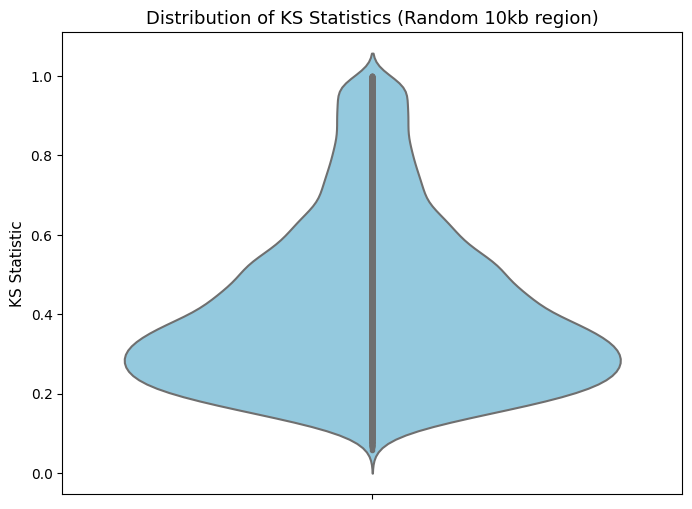

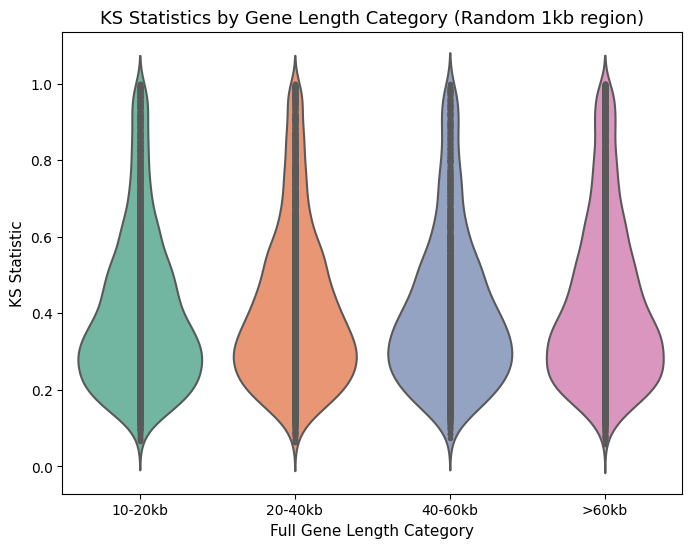

DataFrame saved to /Volumes/T1_Crystal/Greenblatt_lab/DDX3X/DDX3X_KS_results_10kb.csv


In [16]:
# Generator that yields transcript length, KS statistic, and transcript attributes
def ks_generator_random_with_attrs(count_vectors, transcripts):
    """
    For each transcript, if its length is at least 1000 nt, randomly sample a 1 kb region,
    compute the KS statistic between the actual counts (normalized) and a stimulated profile (ones).
    Yield a tuple containing:
      - full transcript length,
      - KS statistic,
      - gene_name,
      - transcript_id,
      - gene_id.
    """
    for vec_actual_full, tran in zip(count_vectors, transcripts):
        transcript_length = len(vec_actual_full)
        if transcript_length < 10000:
            continue
        
        # Choose a random start position such that a 1 kb window fits within the transcript.
        start = random.randint(0, transcript_length - 10000)
        vec_actual = np.array(vec_actual_full[start:start+10000])
        vec_stim = np.ones(10000, dtype=int)
        
        # Skip if no reads in the window or if the stimulated sum is zero (shouldn't happen)
        if vec_actual.sum() == 0 or vec_stim.sum() == 0:
            continue
        
        # Normalize to get density profiles
        norm_actual = vec_actual / vec_actual.sum()
        norm_stim = vec_stim / vec_stim.sum()
        
        # Compute cumulative distributions (CDFs)
        cdf_actual = np.cumsum(norm_actual)
        cdf_stim = np.cumsum(norm_stim)
        
        # Calculate the KS statistic as the maximum absolute difference between the CDFs
        ks = np.max(np.abs(cdf_actual - cdf_stim))
        
        # Extract transcript attributes from the transcript object
        gene_name_value = tran.attr["gene_name"]
        transcript_id_value = tran.attr["transcript_id"]
        gene_id_value = tran.attr["gene_id"]
        
        yield transcript_length, ks, gene_name_value, transcript_id_value, gene_id_value

# Process each transcript from human_transcripts and DDX3X count vectors.
results = list(ks_generator_random_with_attrs(DDX3X_count_vectors, human_transcripts))
if results:
    gene_lengths, ks_values, gene_names, transcript_ids, gene_ids = zip(*results)
else:
    gene_lengths, ks_values, gene_names, transcript_ids, gene_ids = ([], [], [], [], [])

# Create a DataFrame with the results
df = pd.DataFrame({
    "GeneName": gene_names,
    "TranscriptID": transcript_ids,
    "GeneID": gene_ids,
    "GeneLength": gene_lengths,
    "KS": ks_values
})


# bins = [1000, 2000, 4000, 6000, np.inf]
# labels = ["1-2kb", "2-4kb", "4-6kb", ">6kb"]

bins = [10000, 20000, 40000, 60000, np.inf]  
labels = ["10-20kb", "20-40kb", "40-60kb", ">60kb"]  

# Assign each gene length to a category
df["LengthCategory"] = pd.cut(df["GeneLength"], bins=bins, labels=labels, right=False)

# -------------------------------
# Plot 1: Overall KS Distribution
# -------------------------------
plt.figure(figsize=(8, 6))
sns.violinplot(y=df["KS"], inner="point", color="skyblue")
plt.ylabel("KS Statistic", fontsize=11)
plt.title("Distribution of KS Statistics (Random 10kb region)", fontsize=13)
plt.savefig(os.path.join(DDX3X_plot_path, "KS_statistics_distribution_random_1kb_v2.png"), dpi=600)
plt.show()

# --------------------------------------------------
# Plot 2: KS Distribution by Gene Length Category
# --------------------------------------------------
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, x="LengthCategory", y="KS", inner="point", palette="Set2")
plt.xlabel("Full Gene Length Category", fontsize=11)
plt.ylabel("KS Statistic", fontsize=11)
plt.title("KS Statistics by Gene Length Category (Random 1kb region)", fontsize=13)
plt.savefig(os.path.join(DDX3X_plot_path, "KS_statistics_distribution_by_length_random_1kb_v2.png"), dpi=600)
plt.show()

# save the data frame
# print(df.head())
output_csv = os.path.join(DDX3X_output_path, "DDX3X_KS_results_10kb.csv")
df.to_csv(output_csv, index=False)
print(f"DataFrame saved to {output_csv}")

scaled Poe/UBR4 read density

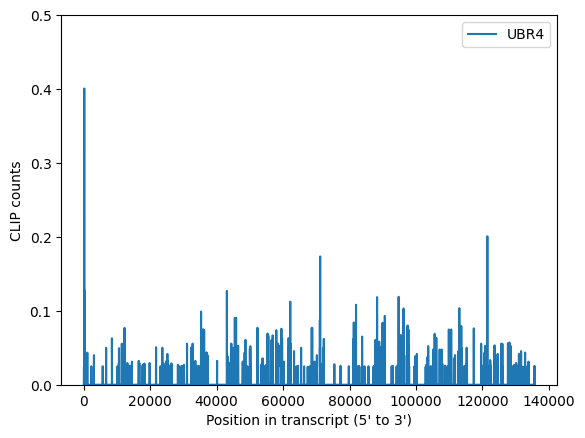

In [36]:
# ----- DDX3X CLIP Plot -----
# DDX3X CLIP count max is 0.4
my_transcript = human_transcripts[407]
my_vector = DDX3X_count_vectors[407]

plt.figure()
plt.plot(my_vector, label="UBR4")
plt.xlabel("Position in transcript (5' to 3')")
plt.ylabel("CLIP counts")

# Set y-axis limit to be X times the average density
avg_density = np.mean(my_vector)
plt.ylim(0, 0.5)

plt.legend()
plt.savefig(os.path.join(DDX3X_plot_path, "UBR4 read counts bar plot v2.png"), dpi=1200)
plt.show()

Clean dataframe

In [19]:
input_csv = "/Users/crystalshan/Desktop/Greenblatt_Lab/cumulative fractions/DDX3X_KS_results_10kb.csv"
output_csv = "/Users/crystalshan/Desktop/Greenblatt_Lab/cumulative fractions/DDX3X_KS_10kb_longest_only.csv"

# Read the CSV with comma delimiter, forcing GeneName to be string
df = pd.read_csv(input_csv, sep=",", dtype={"GeneName": str})

# Group by GeneName and pick the row where GeneLength is maximum
df_longest = df.loc[df.groupby("GeneName")["GeneLength"].idxmax()]

# Write out the filtered DataFrame with all fields quoted
df_longest.to_csv(output_csv, index=False, quoting=csv.QUOTE_ALL)

print(f"Filtered file saved to {output_csv}")





Filtered file saved to /Users/crystalshan/Desktop/Greenblatt_Lab/cumulative fractions/DDX3X_KS_10kb_longest_only.csv


## use K-S statistics to see if these values are statistically significant

In [ ]:
# # Perform the two-sample Kolmogorov-Smirnov test
# ks_statistic, p_value = ks_2samp(sample1, sample2)

# # Determine statistical significance
# alpha = 0.05  # 5% significance level
# if p_value < alpha:
#     print("Reject the null hypothesis: The distributions are significantly different.")
# else:
#     print("Fail to reject the null hypothesis: The distributions are not significantly different.")

In [ ]:


# Flatten the arrays (filtering out transcripts with zero total counts if necessary)
flat_human = np.concatenate([np.array(vec) for vec in human_count_vectors if np.sum(vec) > 0])
flat_fly = np.concatenate([np.array(vec) for vec in fly_count_vectors if np.sum(vec) > 0])

ks_stat, p_value = ks_2samp(flat_human, flat_fly)
print("KS statistic:", ks_stat)
print("p-value:", p_value)
